In [1]:
%load_ext autoreload
%autoreload 2

# Explore the columns of data and find outliers
import pandas as pd
import numpy as np
import os
import datetime
from typing import List, Tuple, Dict, Any, Union, Callable

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, spearmanr

plt.rcParams.update(bundles.beamer_moml())

# Update the font
plt.rcParams["font.family"] = "serif"

# Update the plt savefig path
SAVE_DIR = '../../figures/'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'jpg'
plt.rcParams["savefig.directory"] = SAVE_DIR

# Dataset Loading & Preprocess

This section loads the datasets that will be used for exploration into the RAM.
- `charts_df` is responsible for the rankings of the songs of different days and regions
- `audio_df` is responsible for the audio features, which are fetched by using Spotify API in the `data_preprocess.ipynb` notebook.

In [2]:
REFRESH_DATA = True
CHARTS_PATH = '../../data/charts_processed.csv'
AUDIO_PATH = '../../data/audio_features_processed.csv'


In [3]:
if REFRESH_DATA:

    # Load the datasets into dataframes. Read the date column as datetime.date
    charts_df = pd.read_csv(CHARTS_PATH, parse_dates=['date'])

charts_df['date'] = pd.to_datetime(charts_df['date'])

# Display the first few rows of the DataFrame to verify
charts_df.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [4]:
if REFRESH_DATA:
    # Load the audio features dataset
    audio_df = pd.read_csv(AUDIO_PATH)

    # Change the column-name of 'id' to 'track_id' to match the charts_df
    audio_df.rename(columns={'id': 'track_id'}, inplace=True)
    print(audio_df.head())


   acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0       0.18700         0.852       195840   0.773          0.000030    8   
1       0.00431         0.663       259196   0.920          0.000017   11   
2       0.40000         0.761       222560   0.838          0.000000    4   
3       0.55100         0.508       205600   0.687          0.000003    0   
4       0.07600         0.899       234320   0.626          0.000000    6   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1590    -2.921     0       0.0776  102.034               4    0.907   
1    0.1010    -4.070     0       0.2260   99.935               4    0.533   
2    0.1760    -3.073     0       0.0502   93.974               4    0.710   
3    0.1260    -4.361     1       0.3260  180.044               4    0.555   
4    0.0631    -4.228     0       0.2920   88.007               4    0.873   

                 track_id  
0  6mICuAdrwEjh6Y6lroV2Kg  
1  7DM4BPaS7

# Data Visualization & Description

In [ ]:
import plotly.express as px

num_of_regional_points = charts_df.groupby('region').count().iloc[:,0]


fig = px.choropleth(num_of_regional_points, 
                    locations=num_of_regional_points.index, 
                    color=num_of_regional_points.values,
                    locationmode='country names',
                    color_continuous_scale='Blues',
                    title="Number of regional points")
fig.show()


# Data Preprocessing
This part is optional and processed data can be used instead.

In [5]:
# For now only restrict the dataset to top200 charts for stream/ranking analysis.
charts_df = charts_df[charts_df["chart"] == "top200"]
charts_df["track_id"] = charts_df["url"].apply(lambda x: x.split("/")[-1])

# Utility Functions
This section imports some important utility functions.

In [8]:
# Set that each time a library is imported, refresh 
%load_ext autoreload
import sys
sys.path.append(os.path.abspath('..'))

from utils.charts import get_charts_by_date, get_charts_by_region
from utils.regions import calculate_popularity_metrics,calculate_popularity_metrics_weekly


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Use case of some utility functions
turkey_df = get_charts_by_region(charts_df, 'Turkey', seperete_dict=False)
get_charts_by_date(turkey_df, ('2019-01-01', '2019-12-31'))

,title,rank,date,artist,url,region,chart,trend,streams,track_id
3773532,Aşk Bitsin,44,2019-01-03,Buray,https://open.spotify.com/track/7KwJ77WnVmphcdS...,Turkey,top200,MOVE_DOWN,30777.0,7KwJ77WnVmphcdSDtIHe47
3773966,Bu Gece,45,2019-01-03,Ceg,https://open.spotify.com/track/2DTLzghmLMDNvTY...,Turkey,top200,MOVE_UP,30536.0,2DTLzghmLMDNvTYe67ffuD
3785446,Bir İhtimal Biliyorum,1,2019-01-01,Gülşen,https://open.spotify.com/track/24mpJgP2YZUBif9...,Turkey,top200,SAME_POSITION,108528.0,24mpJgP2YZUBif9NvmYyh4
3785447,3 2 1,2,2019-01-01,Ben Fero,https://open.spotify.com/track/15DPWEQ73JEW3pf...,Turkey,top200,SAME_POSITION,65605.0,15DPWEQ73JEW3pfyU6EcmR
3785448,Sana Doğru,3,2019-01-01,Bora Duran,https://open.spotify.com/track/79sYvkdnJGFrYx6...,Turkey,top200,SAME_POSITION,63799.0,79sYvkdnJGFrYx67nBL5Nk
...,...,...,...,...,...,...,...,...,...,...
10855423,Olmasada Olur,196,2019-12-31,No.1,https://open.spotify.com/track/6L1zNBkpGdYlNof...,Turkey,top200,NEW_ENTRY,23209.0,6L1zNBkpGdYlNofoca1KmH
10855424,Dünya'dan Atlas'a,197,2019-12-31,Şehinşah,https://open.spotify.com/track/0ewiq9snqyF3dUL...,Turkey,top200,MOVE_DOWN,23195.0,0ewiq9snqyF3dULzbMqI3J
10855425,Sana Doğru,198,2019-12-31,Bora Duran,https://open.spotify.com/track/79sYvkdnJGFrYx6...,Turkey,top200,NEW_ENTRY,23135.0,79sYvkdnJGFrYx67nBL5Nk
10855426,Beyaz,199,2019-12-31,Emir Can İğrek,https://open.spotify.com/track/0HIlnKQV5DYXQL9...,Turkey,top200,MOVE_DOWN,23120.0,0HIlnKQV5DYXQL9Edh90mE


## Popularity Analysis

### Issue with the feature "rank" and "streams"
Using the stream in the analysis is a risky since _same songs, with same audio features, can appear multiple times in a chart list with different rankings_. This would mean that a track $t$ has multiple *streams* and *ranking* values. If we want to find a correlation between an audio feature and the streams/rankings for a given date $[a,a + \Delta t]$, there should be a unique _dependent variable_. One way to solve this problem is using aggragation operations to sum the information of multiple days to get a single value we want to correlate. For example we can assign a unique ranking to every song that appeared in "Top 200" charts of a week. This would mean that we would:

1. Sum all the streams of each tracks
2. Re-organize the ranking charts to give them a unique ranking based on their streams. Notice that lowest (worst) ranking that can be achieved is lesser than 200 unless all the songs that appears in the "Top 200" chart of a week contains only the same tracks.

However this approach also comes with a problem : a track appears in "Top 200" charts in multiple weeks which would mean using information of different time ranges to create a single correlation is wrong as there is a high chance that a track will appear in both weeks with different rankings and streams. Another problem is *amount of streams changes by time* which is expected since "Spotify" gets populer each year, which would result in higher amount of streams (altough with same ranking). With these issues on mind, define _stream proportion_ of a track $t$ as the normalized stream:
$$
\hat s(t,d) = \frac{s(t,d)}{\sum_{i=1}^{200} s(t_i,d)}
$$ where $d$ is the date. Using stream proportion instead of streams and rank would give us a more fair comparison between tracks that appears in different time of year.

### Popularity
Define the k-popularity of a track $t$ as the total number of $Top-k$ apperance of a track between the given range $[a,b]$ :
$$
p(k,t) = \sum_{d=a}^b \mathbb 1[r(t,d) \lt k]
$$
where $\mathbb 1$ is an indicator function and $r(t,d)$ gives us the ranking of a track $t$ on a specific date $d$. To avoid any error, if a track $t$ does not appear on a date $d$, this indicator should always return $0$.

Altough this popularity metric uses the information of how frequent a track appears on a chart, it does not use a metric correlated with streams. Define the average k-stream proportion of a track $t$ as:
$$
s_k(t,d) = \frac{\sum_{d=a}^b \mathbb 1[r(t,d) \lt k]s(t,d)}{\sum_{d=a}^b \mathbb 1[r(t,d) \leq k]}
$$

Final popularity is defined as: $$s_k(t,d) p(k,t)$$ which is simply the sum of stream proportions of a track $t$ for its Top-k entries.


First let us show that sum of stream proportion of a track is *highly correlated with the* overall ranking of a track within the given time period. This is expected since stream is highly correlated with the stream proportion.

Calculating metrics for Turkey: 100%|██████████| 1216/1216 [00:05<00:00, 227.38it/s]
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed


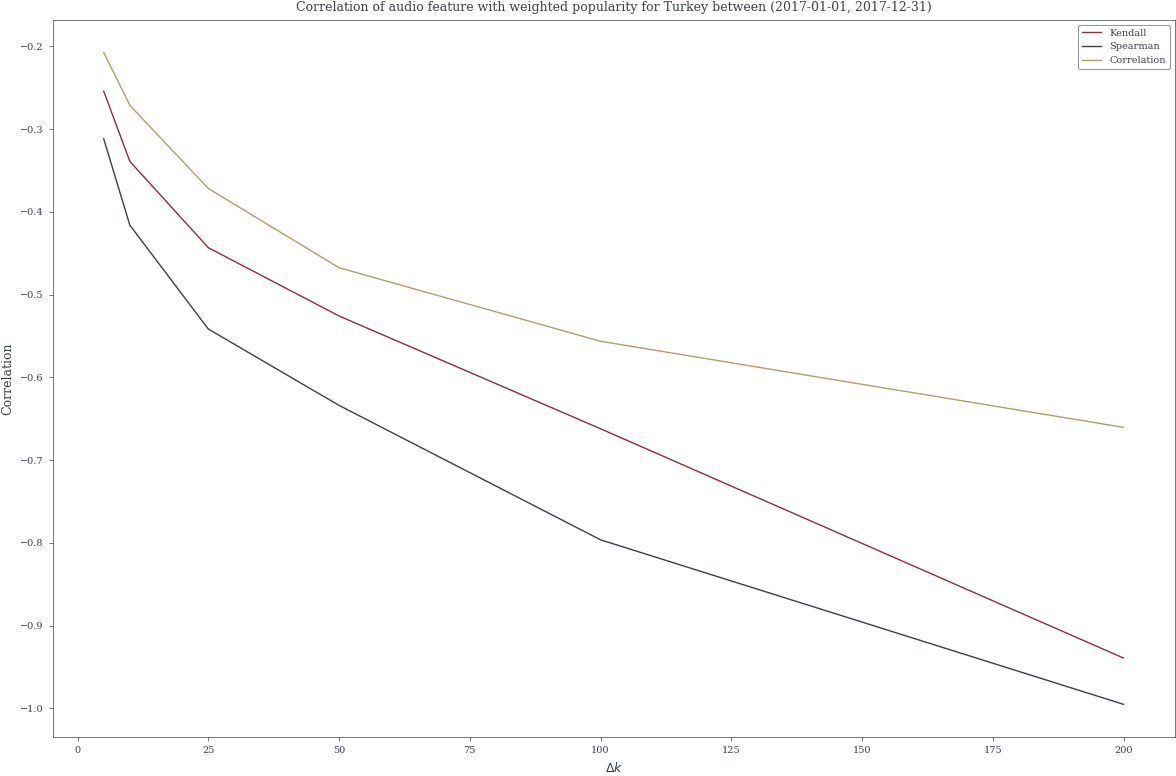

In [9]:

# Get a yearly chart list by summing all the streams and recalculating the ranking
kendel_coeffs = {}
spearman_coeffs = {}
corr_coeffs = {}
TEST_REGION = 'Turkey'
from utils.regions import get_regional_charts_delta_rank

for k in [5,10,25,50,100,200]:
    test_df_yearly = get_regional_charts_delta_rank(
        get_charts_by_region(charts_df, TEST_REGION),
        date = ('2017-01-01', '2017-12-31'),
        normalize_streams=False)

    test_df_popularity = calculate_popularity_metrics(
        charts_df,
        TEST_REGION,
        ('2017-01-01', '2017-12-31'),
        delta_k = k,
    )

    test_df_unique = test_df_popularity.drop_duplicates(subset="track_id", inplace=False)
    test_df_unique['weighted_popularity'] = test_df_unique['popularity'] * test_df_unique['average_stream_proportion']

    # sort by popularity
    test_df_unique.sort_values('weighted_popularity', ascending=False, inplace=True)
    test_df_unique.reset_index(inplace=True)

    # Get the top 5 tracks
    test_df_unique.head(5)

    # Compare the two list and their rankings
    x = []  
    y = []
    for track_id in test_df_unique["track_id"].unique():
        x.append(test_df_unique[test_df_unique["track_id"] == track_id]["weighted_popularity"].values[0])
        y.append(test_df_yearly[test_df_yearly["track_id"] == track_id]["delta_rank"].values[0])

    kendel_coeffs[k] = kendalltau(x, y)
    spearman_coeffs[k] = spearmanr(x, y)
    corr_coeffs[k] = np.corrcoef(x, y)


# Plot the coeffs
plt.figure(figsize=(12, 8))
plt.plot(kendel_coeffs.keys(), [kendel_coeffs[k][0] for k in kendel_coeffs.keys()], label="Kendall")
plt.plot(spearman_coeffs.keys(), [spearman_coeffs[k][0] for k in spearman_coeffs.keys()], label="Spearman")
plt.plot(corr_coeffs.keys(), [corr_coeffs[k][0][1] for k in corr_coeffs.keys()], label="Correlation")
plt.title(f'Correlation of audio feature with weighted popularity for {TEST_REGION} between (2017-01-01, 2017-12-31)')
plt.xlabel('$ \Delta k$')
plt.ylabel('Correlation')
plt.tight_layout()
plt.legend()

In [10]:
TEST_REGION = 'United States'
test_df = calculate_popularity_metrics(
    charts_df,
    TEST_REGION,
    ('2017-01-01', '2018-01-01'),
    delta_k = 200,
)

Calculating metrics for United States: 100%|██████████| 1939/1939 [00:08<00:00, 225.16it/s]


Index(['title', 'rank', 'date', 'artist', 'url', 'region', 'chart', 'trend',
       'streams', 'track_id', 'stream_proportion', 'popularity',
       'average_stream_proportion', 'weighted_popularity'],
      dtype='object')


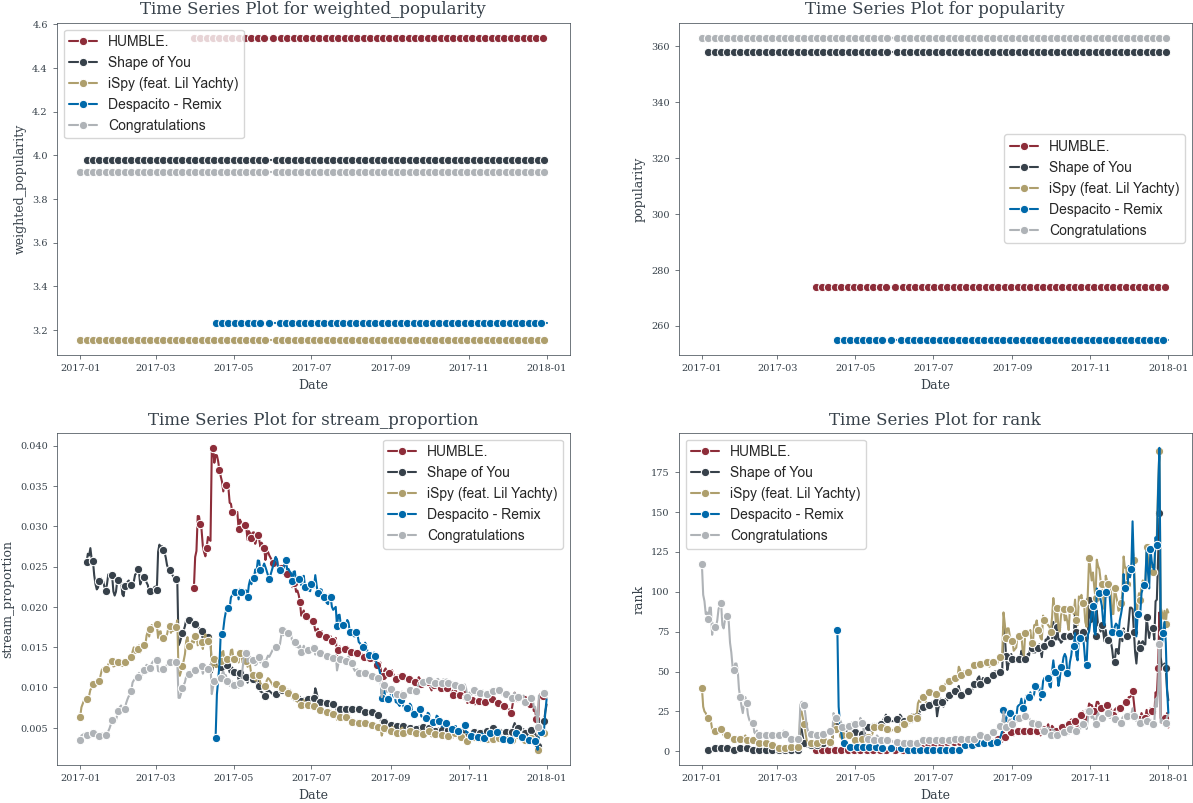

In [11]:
# Get the most popular songs
import matplotlib.pyplot as plt
from utils.visualization import plot_multiple_tracks_time_series,save_current_plot
from utils.tracks import get_track_artist,get_track_title

# Use stream_proportion_average[track_id] *  popularity[track_id] to create a weighted popularity score
test_df['weighted_popularity'] = test_df['popularity'] * test_df['average_stream_proportion']
popularities_sorted = test_df.sort_values('weighted_popularity', ascending=False).set_index('track_id')['weighted_popularity'].to_dict()
popular_track_ids = np.random.choice(list(popularities_sorted.keys())[:5], 5, replace=False)
popular_tracks_df = []
popular_track_labels = []
for track_id in popular_track_ids:
    track_df = test_df[test_df['track_id'] == track_id]
    popular_tracks_df.append(track_df)
    popular_track_labels.append(f"{get_track_title(track_df,track_id)}")

print(test_df.columns)

y_columns = ['weighted_popularity','popularity','stream_proportion','rank']

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through each column and create a plot
for i, y_col in enumerate(y_columns):
    plot_multiple_tracks_time_series(
        popular_tracks_df,
        "date",
        y_col,
        title=f'Time Series Plot for {y_col}',
        labels = popular_track_labels,
        xlabel='Date',
        ylabel=y_col,
        ax=axs[i],
        marker_every=5  # Show a marker every 5 points
    )

save_current_plot(f"time_series_plot_{TEST_REGION}_delta_{25}.png")


# Make the legends smaller
for ax in axs:
    ax.legend(fontsize='small')
plt.tight_layout()
plt.show()



In [14]:
# Plot the heatmap of the popularity scores with respect to audio features
AUDIO_FEATURES = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# Join the audio features the weighted_popularity and popularity scores
# audio_df_with_popularity = audio_df.join(test_df[['track_id','weighted_popularity','popularity']].drop_duplicates(subset="track_id"), on='track_id')

country_list = ["United States"]
k_range = [50,100,200]
corr_dict = {}
spearman_corr_dict = {}
kendell_corr_dict = {}
for country in country_list:
    corr_list = []
    spearman_corr_list = []
    kendell_corr_list = []
    for k in k_range:
        test_df = calculate_popularity_metrics(
            charts_df,
            country,
            ('2018-01-01', '2019-12-31'),
            delta_k = k
        )
        test_df['weighted_popularity'] = test_df['popularity'] * test_df['average_stream_proportion']
        corr = test_df[['track_id','weighted_popularity']].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id").corr()
        spearman_corr = test_df[['track_id','weighted_popularity']].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id").corr(method='spearman')
        kendal_corr = test_df[['track_id','weighted_popularity']].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id").corr(method='kendall')

        corr_list.append(corr)
        spearman_corr_list.append(spearman_corr)
        kendell_corr_list.append(kendal_corr)

    corr_dict[country] = corr_list
    spearman_corr_dict[country] = spearman_corr_list
    kendell_corr_dict[country] = kendell_corr_list


Calculating metrics for United States: 100%|██████████| 3934/3934 [00:36<00:00, 106.73it/s]


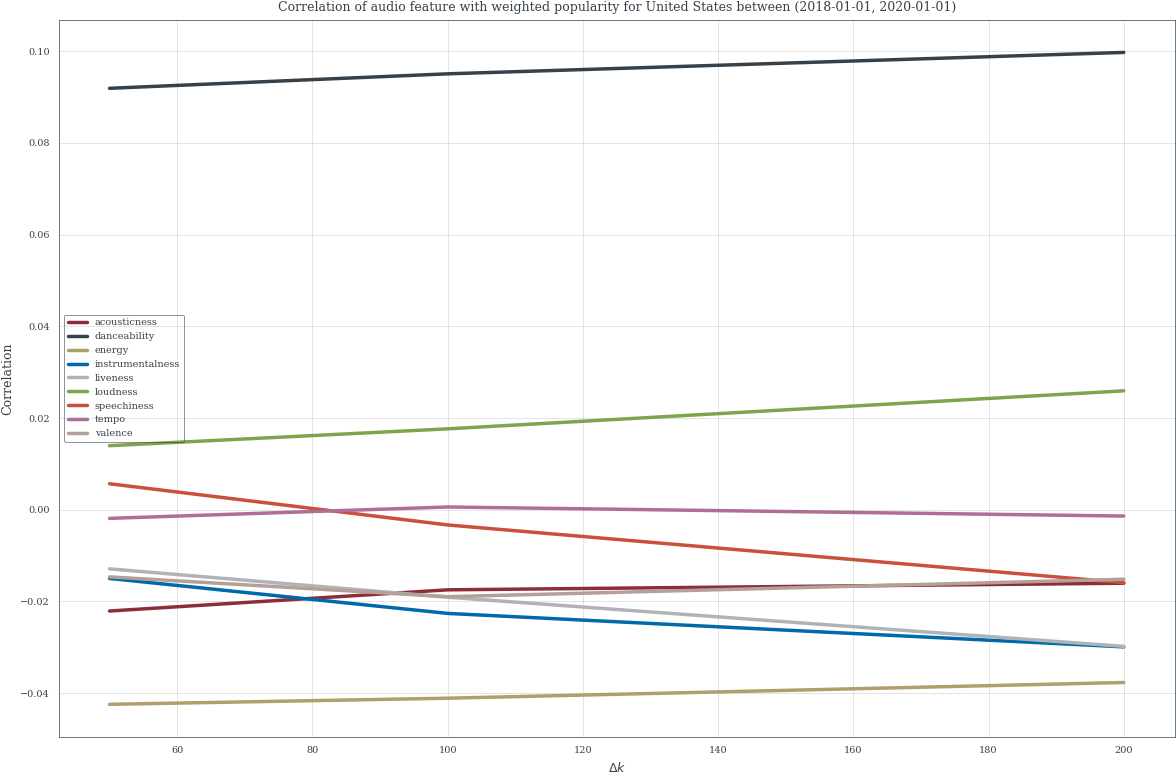

In [16]:
# For every plot, create a 2x2 grid of subplots
# Loop through each country and create a plot
for i, country in enumerate(country_list):
    plt.figure(figsize=(12, 8))
    for audio_feature in AUDIO_FEATURES:
        plt.plot(k_range, [corr_dict[country][j][audio_feature]['weighted_popularity'] for j in range(len(k_range))], label=audio_feature,
                 linewidth=2.5)
        
        
    plt.title(f'Correlation of audio feature with weighted popularity for {country} between (2018-01-01, 2020-01-01)')
    plt.xlabel('$ \Delta k$')
    plt.ylabel('Correlation')
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join("/Users/kbora/Documents/Spoti-Youtube/data-literacy-project/DataLiteracy-MusicAnalysis/figures/correlation_plots",f'popularitycorrelation_{country}.png'))

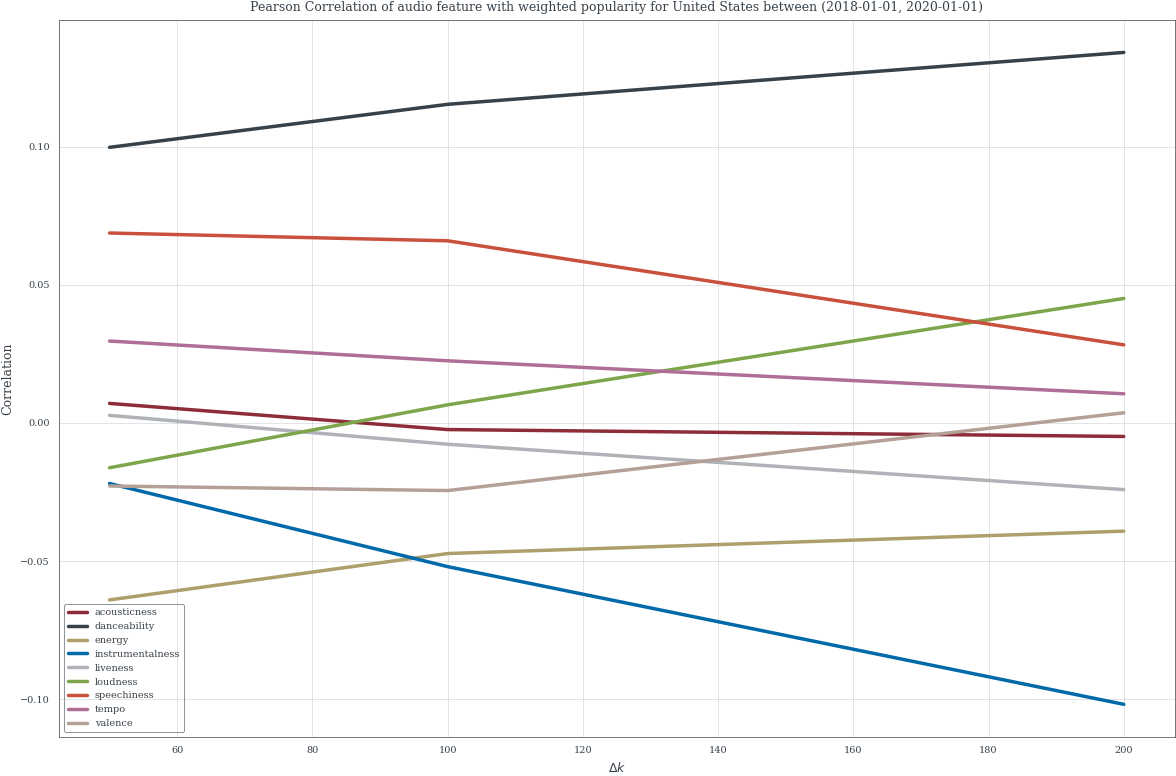

In [17]:
# For every plot, create a 2x2 grid of subplots
# Loop through each country and create a plot
for i, country in enumerate(country_list):
    plt.figure(figsize=(12, 8))
    for audio_feature in AUDIO_FEATURES:
        plt.plot(k_range, [spearman_corr_dict[country][j][audio_feature]['weighted_popularity'] for j in range(len(k_range))], label=audio_feature,
                 linewidth=2.5)
        
        
    plt.title(f'Pearson Correlation of audio feature with weighted popularity for {country} between (2018-01-01, 2020-01-01)')
    plt.xlabel('$ \Delta k$')
    plt.ylabel('Correlation')
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join("/Users/kbora/Documents/Spoti-Youtube/data-literacy-project/DataLiteracy-MusicAnalysis/figures/correlation_plots",f'spearman_popularitycorrelation_{country}.png'))

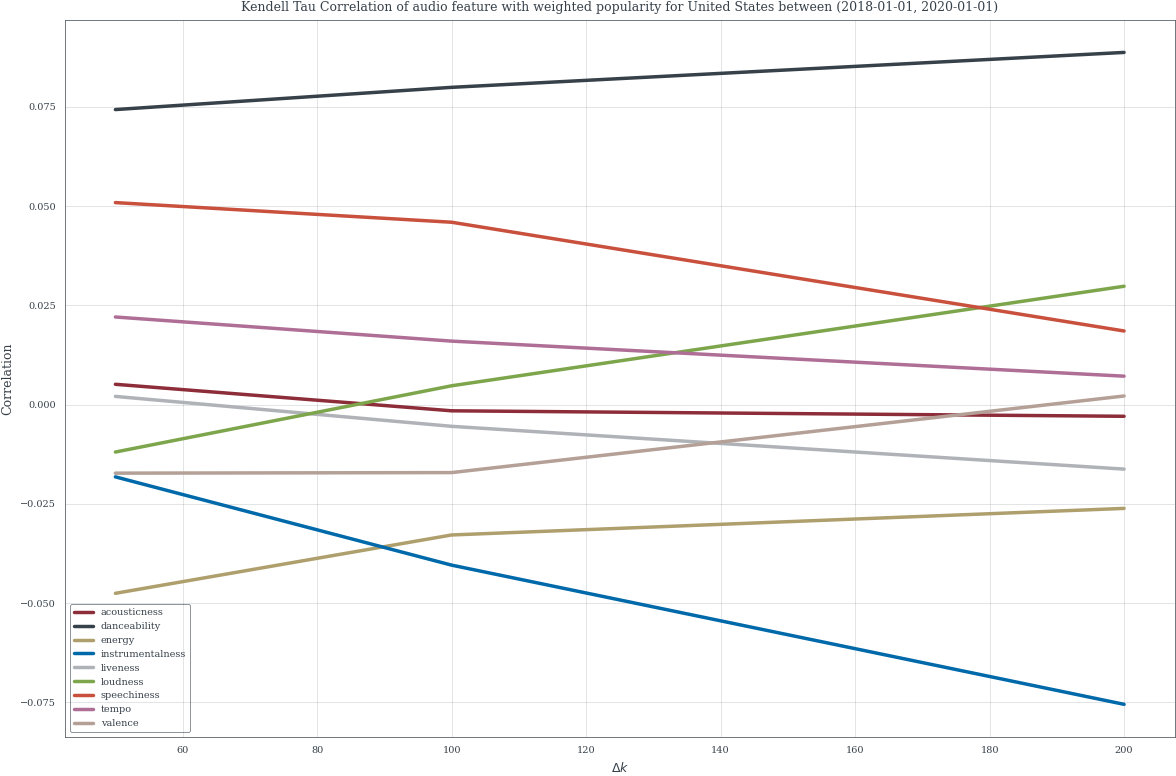

In [18]:
# For every plot, create a 2x2 grid of subplots
# Loop through each country and create a plot
for i, country in enumerate(country_list):
    plt.figure(figsize=(12, 8))
    for audio_feature in AUDIO_FEATURES:
        plt.plot(k_range, [kendell_corr_dict[country][j][audio_feature]['weighted_popularity'] for j in range(len(k_range))], label=audio_feature,
                 linewidth=2.5)
        
        
    plt.title(f'Kendell Tau Correlation of audio feature with weighted popularity for {country} between (2018-01-01, 2020-01-01)')
    plt.xlabel('$ \Delta k$')
    plt.ylabel('Correlation')
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join("/Users/kbora/Documents/Spoti-Youtube/data-literacy-project/DataLiteracy-MusicAnalysis/figures/correlation_plots",f'kendell_tau_popularitycorrelation_{country}.png'))

# Popularity over time

In [29]:
TEST_REGION = 'United States'

test_df_dict = calculate_popularity_metrics_weekly(
    charts_df,
    "Germany",
    ('2017-01-01', '2017-12-01'),
    delta_k = 25,
    delta_t= 14
)

Calculating metrics for Germany: 100%|██████████| 270/270 [00:00<00:00, 1934.29it/s]


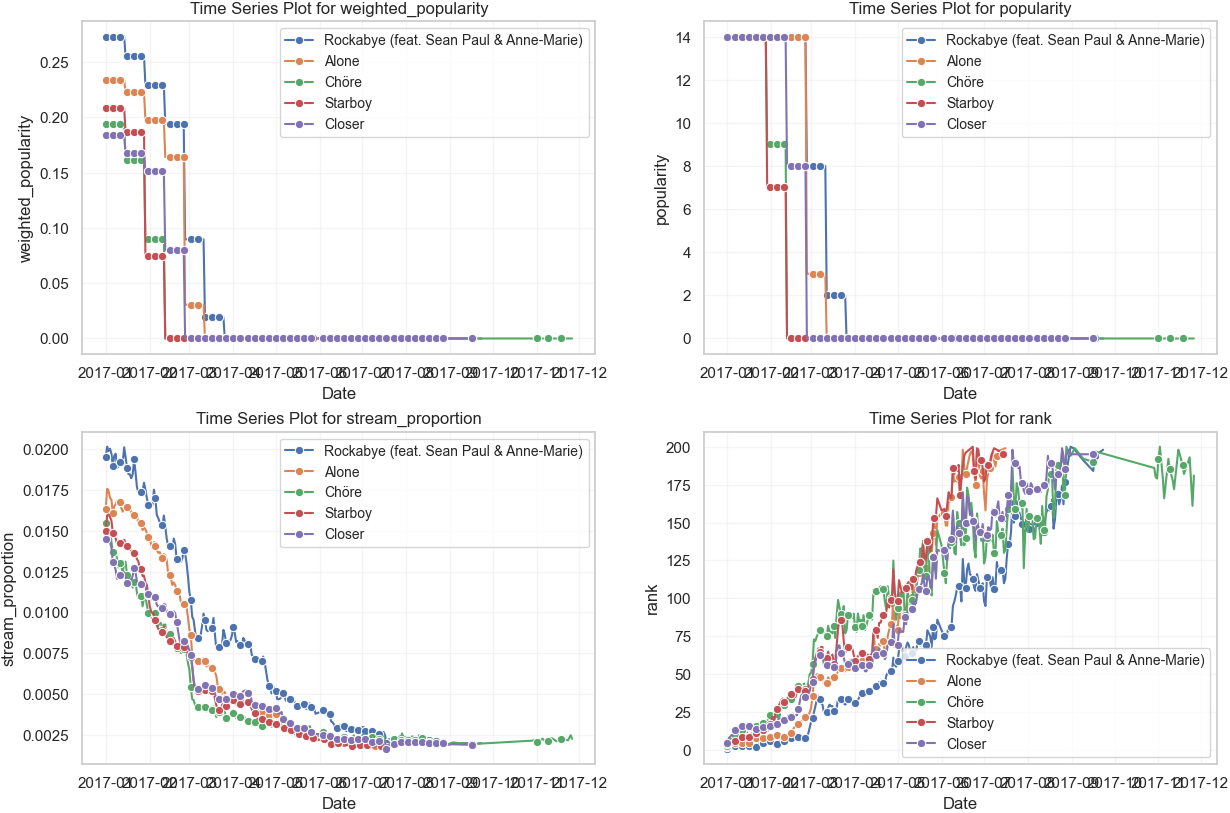

In [30]:
# choose a top track and plot thep popularity over time

concatted_list = []
for key in test_df_dict.keys():
    concatted_list.append(test_df_dict[key])

test_df = pd.concat(concatted_list)
# Choose top 5 unique tracks
unique_track_ids = test_df["track_id"].unique()[:5]
y_columns = ['weighted_popularity','popularity','stream_proportion','rank']
popular_tracks_df = [test_df[test_df["track_id"] == track_id] for track_id in unique_track_ids]
popular_track_labels = [f"{get_track_title(test_df[test_df['track_id'] == track_id],track_id)}" for track_id in unique_track_ids]
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through each column and create a plot
for i, y_col in enumerate(y_columns):
    plot_multiple_tracks_time_series(
        popular_tracks_df,
        "date",
        y_col,
        title=f'Time Series Plot for {y_col}',
        labels = popular_track_labels,
        xlabel='Date',
        ylabel=y_col,
        ax=axs[i],
        marker_every=5  # Show a marker every 5 points
    )

save_current_plot(f"time_series_plot_{TEST_REGION}_delta_{25}.png")


# Make the legends smaller
for ax in axs:
    ax.legend(fontsize='small')
plt.tight_layout()
plt.show()


Since popularity is defined as the sum of the stream proportions, we can say that popularity with respect to $k=200$ is equalivent to the total number of stream proportion of a track within two date boundaries. 

We can claim that **"Yearly popularity ranking is highly correlated as the yearly number of stream ranking**.

Calculating metrics for Turkey: 100%|██████████| 1216/1216 [00:05<00:00, 217.70it/s]


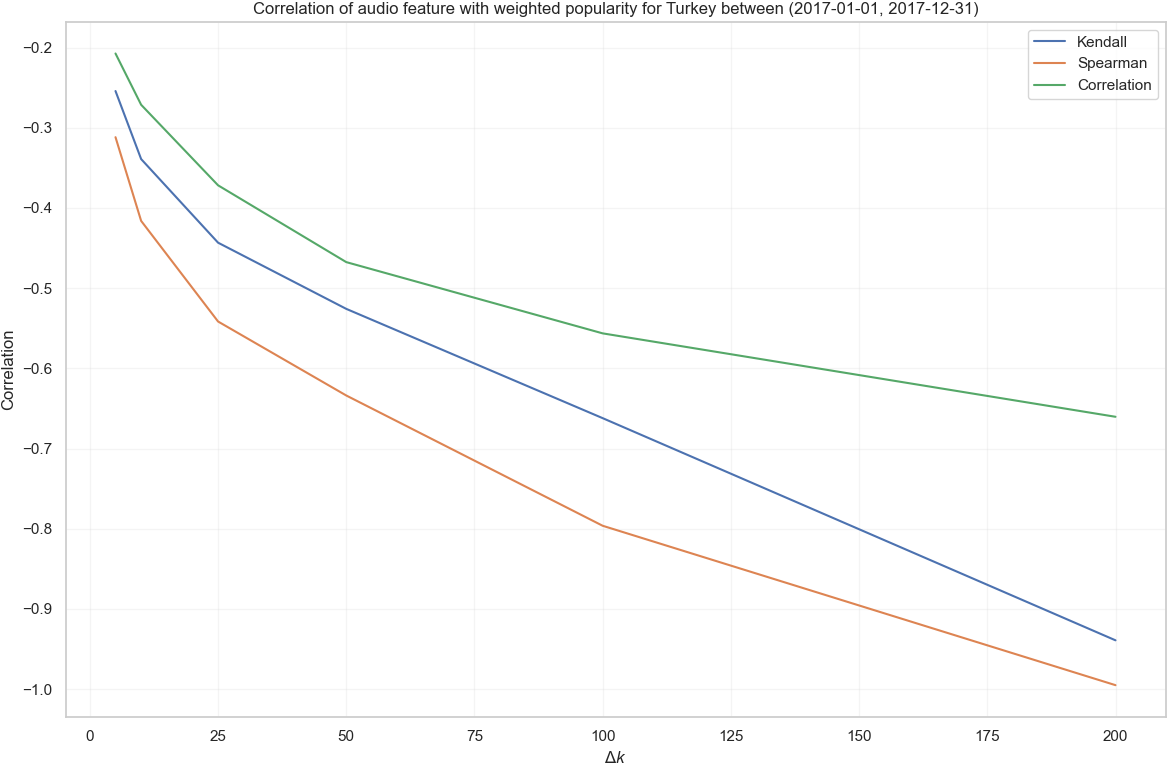

In [67]:
# Get a yearly chart list by summing all the streams and recalculating the ranking
kendel_coeffs = {}
spearman_coeffs = {}
corr_coeffs = {}
TEST_REGION = 'Turkey'
from utils.regions import get_regional_charts_delta_rank

for k in [5,10,25,50,100,200]:
    test_df_yearly = get_regional_charts_delta_rank(
        get_charts_by_region(charts_df, TEST_REGION),
        date = ('2017-01-01', '2017-12-31'),
        normalize_streams=False)

    test_df_popularity = calculate_popularity_metrics(
        charts_df,
        TEST_REGION,
        ('2017-01-01', '2017-12-31'),
        delta_k = k,
    )

    test_df_unique = test_df_popularity.drop_duplicates(subset="track_id", inplace=False)
    test_df_unique['weighted_popularity'] = test_df_unique['popularity'] * test_df_unique['average_stream_proportion']

    # sort by popularity
    test_df_unique.sort_values('weighted_popularity', ascending=False, inplace=True)
    test_df_unique.reset_index(inplace=True)

    # Get the top 5 tracks
    test_df_unique.head(5)

    # Compare the two list and their rankings
    x = []  
    y = []
    for track_id in test_df_unique["track_id"].unique():
        x.append(test_df_unique[test_df_unique["track_id"] == track_id]["weighted_popularity"].values[0])
        y.append(test_df_yearly[test_df_yearly["track_id"] == track_id]["delta_rank"].values[0])

    kendel_coeffs[k] = kendalltau(x, y)
    spearman_coeffs[k] = spearmanr(x, y)
    corr_coeffs[k] = np.corrcoef(x, y)


# Plot the coeffs
plt.figure(figsize=(12, 8))
plt.plot(kendel_coeffs.keys(), [kendel_coeffs[k][0] for k in kendel_coeffs.keys()], label="Kendall")
plt.plot(spearman_coeffs.keys(), [spearman_coeffs[k][0] for k in spearman_coeffs.keys()], label="Spearman")
plt.plot(corr_coeffs.keys(), [corr_coeffs[k][0][1] for k in corr_coeffs.keys()], label="Correlation")
plt.title(f'Correlation of audio feature with weighted popularity for {TEST_REGION} between (2017-01-01, 2017-12-31)')
plt.xlabel('$ \Delta k$')
plt.ylabel('Correlation')
plt.tight_layout()
plt.legend()




The results shows that with higher $k$ values, the correlation increases. So for $k=200$, weighted popularity is highly correlated with the total amount of streams **in terms of their rankings**. Yippee <3


![](https://media.printables.com/media/prints/386968/images/3240015_0fcd3dc4-efbe-437b-abb7-bdee355d73bb/thumbs/cover/800x800/jpg/yippee.webp)

Correlation Coefficient: [[ 1.         -0.60236672]
 [-0.60236672  1.        ]]
